## 공매도 거래량 상위 50 종목의 위험도 분류

In [43]:
import pandas as pd
import numpy as np
from pykrx import stock
import warnings
import matplotlib.pyplot as plt
warnings = warnings.filterwarnings('ignore')

#### 코스피 공매도 거래량 상위 50종목의 일일 위험도 산출 함수

In [44]:

def danger(day):

    try: 
        #데이터 불러오기#
        trade = stock.get_market_ohlcv(day)             # 해당 날짜의 KOSPI 종목 주가데이터 
        rank = stock.get_shorting_volume_top50(day)     # 공매도 거래량 상위 50종목
        name = stock.get_market_price_change(day,day)   # 종목명 컬럼 사용을 위한 데이터


        #데이터 전처리 과정# 
        name.drop(['시가','종가','거래량','거래대금','등락률'], axis=1,inplace=True)    # 종목명 추출

        many = pd.read_csv('./5years2.csv')     # 최근 5년동안 공매도 과열종목으로 지정된 기업 데이터
        many.drop(['Unnamed: 0'],axis=1,inplace=True)

        rank_trade = pd.merge(rank,trade,on="티커", how='inner')    # rank와 trade 데이터 프레임 병합
        rank_name = pd.merge(rank_trade,name,on='티커',how='inner')     # rank_trade 데이터에 종목명 추가
        rank_name.drop(['총거래대금','고가','저가','거래량','거래대금','변동폭','주가수익률'],axis=1, inplace=True)  # 컬럼 정리
        rank_name =rank_name[['종목명','시가','종가','등락률','공매도거래대금','직전40일거래대금평균', 
                                '공매도거래대금증가율','공매도비중','직전40일공매도평균비중','공매도비중증가율','순위']]    # 컬럼 순서 변경

        rank_name_many = pd.merge(rank_name,many,on='종목명',how='left')       # 공매도 과열종목 지정되었었던 종목 데이터 추가
        rank_name_many.set_index(['종목명'],inplace=True)   # 인덱스 종목코드(티커) -> 종목명으로 변경
        rank_name_many['과열횟수'] = rank_name_many['과열횟수'].fillna(0)       ## 과열횟수의 결측치를 0으로 대체
        

        #위험도 계산을 위한 for문#
        rank_name_many['위험도수치'] = 0        ## 위험도수치를 계산할 컬럼 생성
 
        for i in range(len(rank_name_many)) :       ## 공매도거래대금증가율로 위험도 측정
                if rank_name_many['공매도거래대금증가율'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['공매도거래대금증가율'][i] >= 2.5 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['공매도거래대금증가율'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['공매도거래대금증가율'][i] >= 1.5 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['공매도거래대금증가율'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :       ## 공매도비중증가율로 위험도 측정
                if rank_name_many['공매도비중증가율'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['공매도비중증가율'][i] >= 2.5 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['공매도비중증가율'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['공매도비중증가율'][i] >= 1.5 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['공매도비중증가율'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :      ## 주가하락률로 위험도 측정
                if rank_name_many['등락률'][i] <= -10.0 :   
                    rank_name_many['위험도수치'][i] += 5   
                elif rank_name_many['등락률'][i] <= -8.0 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['등락률'][i] <= -6.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['등락률'][i] <= -4.0 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['등락률'][i] <= -2.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :           # 5년 과열종목 지정 횟수로 위험도 측정 
                if rank_name_many['과열횟수'][i] >= 5.0 :     
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['과열횟수'][i] >= 4.0 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['과열횟수'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['과열횟수'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['과열횟수'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1


        #위험도 수치를 다시 5개의 level로 분류#
        rank_name_many['위험도'] = ''  
        for i in range(len(rank_name_many)) : 
            if rank_name_many['위험도수치'][i]>= 16.0 :     
                rank_name_many['위험도'][i] ='Level5'
            elif rank_name_many['위험도수치'][i] >= 12.0 :
                rank_name_many['위험도'][i] = 'Level4'
            elif rank_name_many['위험도수치'][i] >= 8.0 : 
                rank_name_many['위험도'][i] = 'Level3'
            elif rank_name_many['위험도수치'][i] >= 4.0 : 
                rank_name_many['위험도'][i] = 'Level2'
            elif rank_name_many['위험도수치'][i] >= 0.0 : 
                rank_name_many['위험도'][i] = 'Level1'
            else:
                rank_name_many['위험도'][i] =np.NaN  
            
        return rank_name_many # 개별 종목의 위험도수치와 위험도가 포함된 데이터프레임 추출
    except:
        return '데이터가 없습니다.'

#### 지정 날짜에 찾는 종목이 공매도거래량상위50종목에 들어가는지 확인하는 함수 #

In [45]:
def choose(data, name):
    if name not in data.index:
        return '오늘은 이 종목이 존재하지 않습니다.'
    elif name in data.index:
        return data.loc[[name]]

#### 2022년 05월 11일의 위험도 산출 예시 

형식 : danger('원하는날짜')

In [46]:
df = danger('20210908')
df

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
아모레퍼시픽,226000,206000,-9.25000,36678206000,8375633072,4.38000,26.46000,20.77000,1.27000,1,2.00000,12,Level4
JW중외제약,27200,26900,-1.10000,742455950,319568709,2.32000,22.60000,10.09000,2.24000,2,0.00000,6,Level2
LG생활건강,1427000,1408000,-3.10000,17442672000,6817999650,2.56000,22.38000,12.20000,1.83000,3,2.00000,9,Level3
금호타이어,5760,6080,3.58000,1096592090,382724874,2.87000,20.10000,10.32000,1.95000,4,2.00000,8,Level3
롯데쇼핑,106500,109000,1.87000,2378958000,882437498,2.70000,18.56000,10.77000,1.72000,5,2.00000,8,Level3
대우조선해양,28250,28400,0.53000,1457912400,1149491575,1.27000,17.94000,11.28000,1.59000,6,1.00000,4,Level2
락앤락,11550,11400,-1.30000,288997500,87393860,3.31000,17.85000,9.80000,1.82000,7,2.00000,9,Level3
삼성SDI,775000,770000,-0.65000,30905319000,9945281375,3.11000,16.97000,4.54000,3.73000,8,0.00000,10,Level3
아이에스동서,51000,50300,-2.33000,445782000,470793138,0.95000,16.56000,13.05000,1.27000,9,0.00000,2,Level1


2022년 5월 11일 공매도 거래량 상위 50종목의 위험도별 개수 시각화 

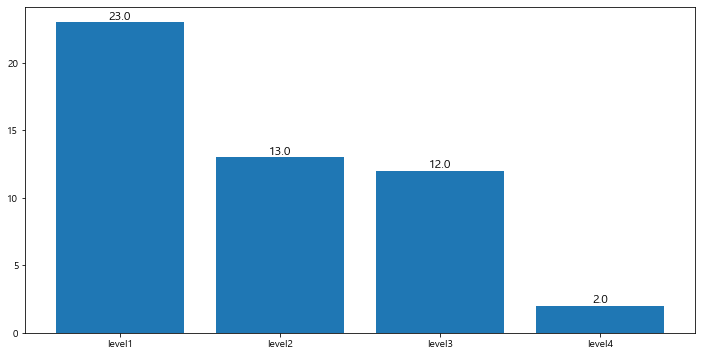

In [47]:
x = ['level1', 'level2', 'level3', 'level4']
y = pd.DataFrame(df['위험도'].value_counts())
plt.figure(figsize=(12,6))
bar = plt.bar(x,y['위험도'])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
plt.show()

#### choose(danger함수로 출력한 데이터프레임)

위 함수를 실행하여 데이터프레임 내의 인덱스(종목명)를 입력하면 입력한 종목만 볼 수 있습니다.

In [48]:
choose(df, '아모레퍼시픽')

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
아모레퍼시픽,226000,206000,-9.25000,36678206000,8375633072,4.38000,26.46000,20.77000,1.27000,1,2.00000,12,Level4


실제로 위험도가 level4로 가장 높게 측정된 금호석유가 그 다음주인 7월 11일에 주가가 전날대비 -7.97% 하락하며 과열종목으로 지정되었습니다.

이런 방식으로 자신이 투자하고 싶은 종목이 공매도 타겟 종목이 될 확률이 높은 종목인지 위 함수를 통해 확인할 수 있습니다.

## 머신러닝을 통한 공매도 주가하락 위험도 예측

### 데이터 추출 및 전처리

In [49]:
from pykrx import stock
import pandas as pd
import numpy as np

* krx 한국거래소에서 공매도 통계 데이터 추출 (start date, end date, 종목 ticker)

In [50]:
val = stock.get_shorting_value_by_date('20180101', '20211130', '090430') # 코스피 공매도 거래대금
bal = stock.get_shorting_balance_by_date('20180101', '20211130', '090430') # 코스피 공매도 잔고
vol = stock.get_shorting_volume_by_date('20180101', '20211130', '090430') # 코스피 공매도 거래량
sta = stock.get_shorting_status_by_date('20180101', '20211130', '090430')

* 해당 종목의 일일 외국인 주식 매수량 추출 (start date, end date, 종목 ticker)

In [51]:
fore = stock.get_market_trading_value_by_date('20180101', '20211130', '090430')
foreign = fore['외국인합계']

* 해당 종목의 전일 대비 주가 등락률 (start date, end date, 종목 ticker)

In [52]:
stock_pct = stock.get_market_ohlcv_by_date('20180101', '20211130', '090430')
stock_pct['Daily_rtn'] = stock_pct['종가'].pct_change()
daily_rtn = stock_pct['Daily_rtn']

* 직전 40 거래일 공매도 거래대금 평균

In [53]:
pd.options.display.float_format = '{:.5f}'.format
val['40일'] = val['공매도'].rolling(40).mean().shift(1)

* 공매도 거래대금 데이터에서 거래대금 증가배율, 공매도 거래비중 추출

In [54]:
val_ = val[40:]
val_['증가배율'] = np.round(val_['공매도'] / val_['40일'], 2)
증가배율 = val_['증가배율']
공매도거래비중 = val_['비중']

* 공매도 잔고 데이터에서 잔고비중 추출

In [55]:
bal # 공매도 잔고 비중
bal['잔고비중'] = bal['비중']
잔고비중 = bal['잔고비중']

* 공매도 잔고수량 데이터 추출

In [56]:
잔고수량 = sta['잔고수량']

* 코스피200 지수 

In [57]:
kospi121 = stock.get_index_fundamental('20180101', '20211130', "1028")
kospi121['kospi200등락률'] = kospi121['등락률']
kospi200 = kospi121['kospi200등락률']

In [58]:
for1 = stock.get_exhaustion_rates_of_foreign_investment('20180101', '20211130', '090430')
for1['외국인 지분율'] = for1['지분율']
forrate = for1['외국인 지분율']

* label에 기준일 이후 40일간 주가 변동률 대입

In [59]:
st = stock.get_market_ohlcv_by_date('20180101', '20211130', '090430')
st['label'] = (st['종가'].shift(-40) - st['종가']) / st['종가']
labels = st['label']

In [60]:
from functools import reduce
import pandas as pd
dfs = [daily_rtn, foreign, 증가배율,공매도거래비중,잔고비중, kospi200, forrate, labels]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='날짜'), dfs)
df_merge.dropna(axis = 0, inplace=True)

In [61]:
df_merge

,Daily_rtn,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율,label
날짜,,,,,,,,
2018-03-02,-0.02131,-7163683500,1.71000,27.47000,2.75000,-1.44000,33.62500,0.21416
2018-03-05,0.00363,-2560482500,0.27000,5.45000,2.67000,-1.22000,33.65625,0.26221
2018-03-06,0.00542,-4399513500,0.30000,6.27000,2.63000,1.93000,33.62500,0.26439
2018-03-07,0.01619,-7419564000,0.69000,8.30000,2.54000,0.22000,33.59375,0.20177
2018-03-08,0.02301,711901500,0.55000,6.90000,2.46000,1.17000,33.56250,0.21107
...,...,...,...,...,...,...,...,...
2021-09-27,-0.00271,4952887000,0.44000,14.63000,1.51000,0.28000,32.06250,-0.05435
2021-09-28,-0.03261,11144491000,1.28000,17.53000,1.57000,-1.16000,32.09375,-0.02528
2021-09-29,0.01124,-1109386500,0.10000,1.72000,1.52000,-1.50000,32.18750,-0.05833


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')

* features와 label 간의 상관관계 확인

<AxesSubplot:>

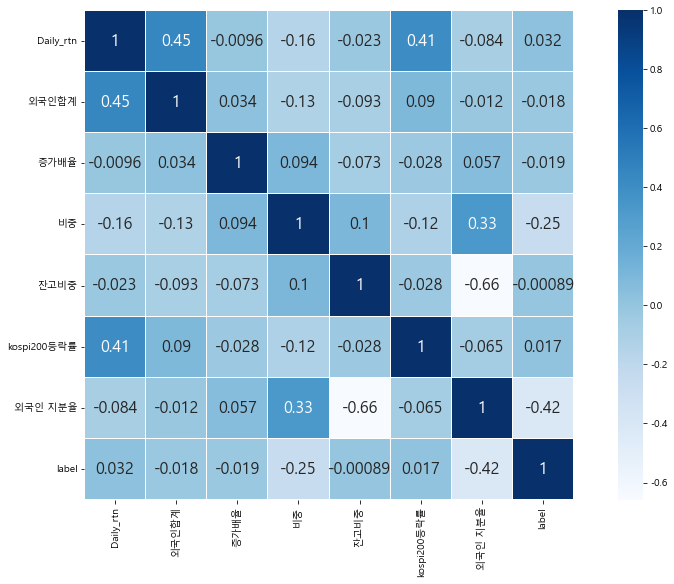

In [63]:
df_merge.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_merge.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 16})

* 다중공선성 발생 가능성이 높은 feature 삭제

In [64]:
df_merge.drop(['Daily_rtn'], axis=1, inplace=True)
df_merge

,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율,label
날짜,,,,,,,
2018-03-02,-7163683500,1.71000,27.47000,2.75000,-1.44000,33.62500,0.21416
2018-03-05,-2560482500,0.27000,5.45000,2.67000,-1.22000,33.65625,0.26221
2018-03-06,-4399513500,0.30000,6.27000,2.63000,1.93000,33.62500,0.26439
2018-03-07,-7419564000,0.69000,8.30000,2.54000,0.22000,33.59375,0.20177
2018-03-08,711901500,0.55000,6.90000,2.46000,1.17000,33.56250,0.21107
...,...,...,...,...,...,...,...
2021-09-27,4952887000,0.44000,14.63000,1.51000,0.28000,32.06250,-0.05435
2021-09-28,11144491000,1.28000,17.53000,1.57000,-1.16000,32.09375,-0.02528
2021-09-29,-1109386500,0.10000,1.72000,1.52000,-1.50000,32.18750,-0.05833


<AxesSubplot:>

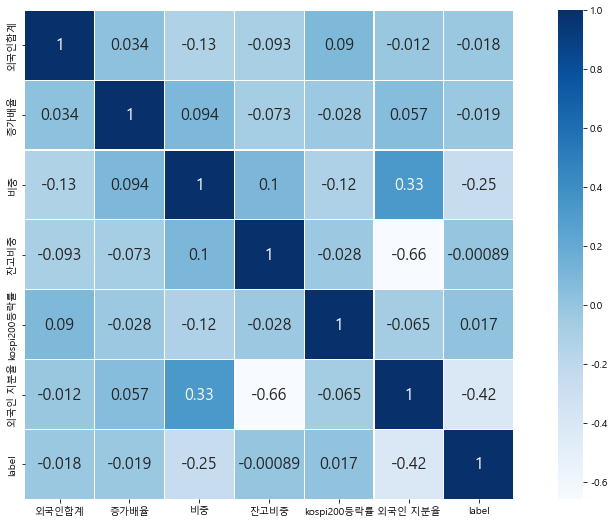

In [65]:
df_merge.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_merge.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 16})

* label을 5일동안 수익률이 -5%일 때 1, 나머지를 0으로 설정

In [66]:
for i in range(len(df_merge)):

    if df_merge['label'][i] <= -0.05:
        df_merge['label'][i] = 1
    else :
        df_merge['label'][i] = 0

In [67]:
df_merge['label'].sum()

382.0

* label을 features가 있는 데이터프레임과 분리

In [68]:
df_data = df_merge.drop(['label'],axis=1)
df_target = df_merge['label']

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [70]:
df_data

,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율
날짜,,,,,,
2018-03-02,-7163683500,1.71000,27.47000,2.75000,-1.44000,33.62500
2018-03-05,-2560482500,0.27000,5.45000,2.67000,-1.22000,33.65625
2018-03-06,-4399513500,0.30000,6.27000,2.63000,1.93000,33.62500
2018-03-07,-7419564000,0.69000,8.30000,2.54000,0.22000,33.59375
2018-03-08,711901500,0.55000,6.90000,2.46000,1.17000,33.56250
...,...,...,...,...,...,...
2021-09-27,4952887000,0.44000,14.63000,1.51000,0.28000,32.06250
2021-09-28,11144491000,1.28000,17.53000,1.57000,-1.16000,32.09375
2021-09-29,-1109386500,0.10000,1.72000,1.52000,-1.50000,32.18750


* '외국인합계'와 '잔고수량'의 값이 커서 MinMaxScaler를 통해 전처리

In [71]:
from sklearn.preprocessing import MinMaxScaler
min = MinMaxScaler()
min_scaled = min.fit_transform(df_data)
minmax_fit = pd.DataFrame(min_scaled, columns=['외국인합계', '증가배율', '비중', '잔고비중', 'kospi200등락률', '외국인 지분율'])
minmax_fit

,외국인합계,증가배율,비중,잔고비중,kospi200등락률,외국인 지분율
0,0.40134,0.01164,0.54428,0.52632,0.37039,0.77961
1,0.43385,0.00184,0.10798,0.50801,0.38347,0.78512
2,0.42086,0.00204,0.12423,0.49886,0.57075,0.77961
3,0.39954,0.00470,0.16445,0.47826,0.46908,0.77410
4,0.45696,0.00375,0.13671,0.45995,0.52556,0.76860
...,...,...,...,...,...,...
879,0.48691,0.00300,0.28988,0.24256,0.47265,0.50413
880,0.53064,0.00872,0.34734,0.25629,0.38704,0.50964
881,0.44410,0.00068,0.03408,0.24485,0.36683,0.52617
882,0.40657,0.00095,0.09194,0.24256,0.47384,0.52066


In [73]:
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


In [74]:
X_train, X_test, y_train, y_test = train_test_split(minmax_fit, df_target, test_size=0.2, random_state=7)

In [75]:
num_folds = 10
scoring = 'roc_auc'

In [76]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


In [77]:
results = []
names = []
num_folds = 10
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=num_folds, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.814881 (0.036140)
LDA: 0.814114 (0.038084)
KNN: 0.918736 (0.020060)
CART: 0.846148 (0.044696)
NB: 0.774195 (0.054062)
SVM: 0.874321 (0.021767)
NN: 0.858954 (0.026882)
AB: 0.906873 (0.024427)
GBM: 0.933946 (0.017523)
RF: 0.945138 (0.014864)
ET: 0.953138 (0.008206)


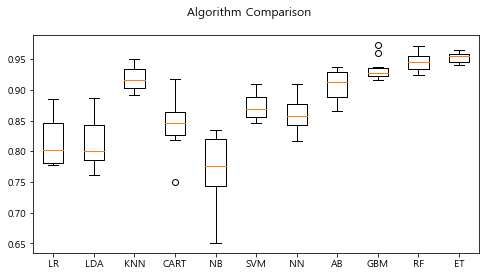

In [78]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()


In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve

In [80]:
n_estimators = [20,50,100,120]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train, y_train)


In [81]:
estimator = grid_result.best_estimator_
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)
pred = estimator.predict(X_test)
print(accuracy_score(y_test, pred))

최고예측 정확도: 0.9231178661540309 최적 하이퍼 파라미터 : {'max_depth': 5, 'n_estimators': 120}
0.8813559322033898


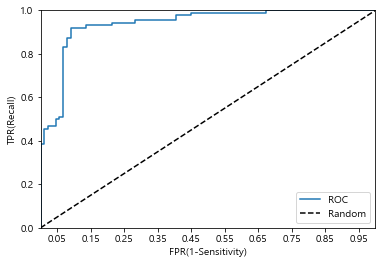

In [82]:
pred_proba_class1 = estimator.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0],5)
plt.plot(fprs, tprs, label='ROC')
plt.plot([0,1],[0,1], 'k--', label='Random')

start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1),2))
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
plt.legend()
plt.show()

In [83]:
print(classification_report(y_test, pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.85      0.92      0.89        89
     class 1       0.91      0.84      0.88        88

    accuracy                           0.88       177
   macro avg       0.88      0.88      0.88       177
weighted avg       0.88      0.88      0.88       177



In [84]:
# threshold 최대값의 인덱스, np.argmax()
# pred_proba_class1 = estimator.predict_proba(X_test)[:,1]
# fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
optimal_idx = np.argmax(tprs - fprs)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 16 , threshold: 0.4092976596046346


In [86]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
pred_proba = estimator.predict_proba(X_test)
custom_threshold = 0.4092976596046346
# Positive 컬럼에 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

# 테스트 레이블 데이터셋: y_test

# 오차행렬
print('오차행렬:', '\n',  confusion_matrix(y_test, custom_predict))
print(classification_report(y_test, custom_predict))

오차행렬: 
 [[81  8]
 [ 8 80]]
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91        89
         1.0       0.91      0.91      0.91        88

    accuracy                           0.91       177
   macro avg       0.91      0.91      0.91       177
weighted avg       0.91      0.91      0.91       177

